In [15]:
import datetime
import warnings
from collections import Counter
from io import StringIO
import pandas as pd
import numpy as np
import statsmodels.api as sm
from joblib import dump
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, roc_curve, auc, \
    roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import datetime
import logging
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns

SCORING = {'accuracy': 'accuracy', 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score),
           'AUC': make_scorer(roc_auc_score)}

## Data Preprocessing

In [2]:
#importing data and creating test/train features
dfApache = pd.read_excel("C:/Users/chels/Desktop/SampleData/ApacheSample.xlsx")
dfJunit = pd.read_excel("C:/Users/chels/Desktop/SampleData/junitSample.xlsx")
dfOkhttp = pd.read_excel("C:/Users/chels/Desktop/SampleData/okhttpSample.xlsx")
dfRetrofit = pd.read_excel("C:/Users/chels/Desktop/SampleData/retrofitSample.xlsx")
dfSpringBoot = pd.read_excel("C:/Users/chels/Desktop/SampleData/springBootSample.xlsx")

# Specify the column name for the labels
label_column = 'label'
message_column = 'new_message1'

def mylog():
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    logfile = "./log/" + str(datetime.datetime.now().month) + "-" + str(datetime.datetime.now().day) + "-" + str(
        datetime.datetime.now().hour) + "-" + str(datetime.datetime.now().minute) + \
              os.path.split(__file__)[-1].split(".")[0] + '.log'
    fileHandler = logging.FileHandler(logfile, mode='w', encoding='UTF-8')
    fileHandler.setLevel(logging.NOTSET)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fileHandler.setFormatter(formatter)
    logger.addHandler(fileHandler)
    return logger

# Define the preprocess_text function to perform text preprocessing steps
def preprocess_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_text = [stemmer.stem(word) for word in filtered_text]

    # Join the processed words back into a single string
    preprocessed_text = ' '.join(stemmed_text)
    
    return preprocessed_text

# Preprocess the commit message text
dfApache['new_message1'] = dfApache['new_message1'].apply(preprocess_text)
dfJunit['new_message1'] = dfJunit['new_message1'].apply(preprocess_text)
dfOkhttp['new_message1'] = dfOkhttp['new_message1'].apply(preprocess_text)
dfRetrofit['new_message1'] = dfRetrofit['new_message1'].apply(preprocess_text)
dfSpringBoot['new_message1'] = dfSpringBoot['new_message1'].apply(preprocess_text)

#splitting the data
apacheTrain, apacheTest = train_test_split(dfApache, test_size=0.15, random_state=42)
junitTrain, junitTest = train_test_split(dfJunit, test_size=0.15, random_state=42)
okhttpTrain, okhttpTest= train_test_split(dfOkhttp, test_size=0.15, random_state=42)
retrofitTrain, retrofitTest = train_test_split(dfRetrofit, test_size=0.15, random_state=42)
springBootTrain, springBootTest = train_test_split(dfSpringBoot, test_size=0.15, random_state=42)

# Extract features using TF-IDF
vectorizer = TfidfVectorizer()
X_trainApache = vectorizer.fit_transform(apacheTrain['new_message1'])
X_testApache = vectorizer.transform(apacheTest['new_message1'])

X_trainJunit = vectorizer.fit_transform(junitTrain['new_message1'])
X_testJunit = vectorizer.transform(junitTest['new_message1'])

X_trainOkhttp = vectorizer.fit_transform(okhttpTrain['new_message1'])
X_testOkhttp = vectorizer.transform(okhttpTest['new_message1'])

X_trainRetrofit = vectorizer.fit_transform(retrofitTrain['new_message1'])
X_testRetrofit = vectorizer.transform(retrofitTest['new_message1'])

X_trainSpringboot = vectorizer.fit_transform(springBootTrain['new_message1'])
X_testSpringboot = vectorizer.transform(springBootTest['new_message1'])

# Get the corresponding labels for the training and test sets
y_trainApache = apacheTrain[label_column]
y_testApache = apacheTest[label_column]

y_trainJunit = junitTrain[label_column]
y_testJunit = junitTest[label_column]

y_trainOkhttp = okhttpTrain[label_column]
y_testOkhttp = okhttpTest[label_column]

y_trainRetrofit = retrofitTrain[label_column]
y_testRetrofit = retrofitTest[label_column]

y_trainSpringboot = springBootTrain[label_column]
y_testSpringboot = springBootTest[label_column]

## KNN Model

In [3]:
def get_score_by_grid(grid: GridSearchCV):
    print("GridSearchCV is complate!")
    accuRank = grid.cv_results_['rank_test_accuracy']
    preMean = grid.cv_results_['mean_test_precision']
    bestParam = grid.cv_results_['params']
    bestIndex = grid.best_index_
    i = bestIndex
    rank = 1

    while preMean[i] < 0.5:
        rank += 1
        indx = 0
        if rank > 20:
            break
        for num in accuRank:
            if num == rank:
                i = indx
                break
            indx += 1
    bestIndex = i

    res = "refit by:" + str(grid.refit) + " Parameters: " + str(bestParam[bestIndex])
    #logger.info(res)
   # print(res)
    return bestParam[bestIndex]

def KNNClassifier(trainFeatures, trainLabels):
    model = KNeighborsClassifier()
    fold = KFold(n_splits=10, random_state=5, shuffle=True)
    parameter = {'n_neighbors': np.arange(1, 10, 1),
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                 }
    grid = GridSearchCV(estimator=model, param_grid=parameter, cv=fold,
                        scoring=SCORING, refit="accuracy", n_jobs=25)
    grid.fit(trainFeatures, trainLabels)
    bestParameter = get_score_by_grid(grid)
    print("KNN Best using %s " % (bestParameter))
    model = KNeighborsClassifier(n_neighbors=bestParameter['n_neighbors'], algorithm=bestParameter['algorithm'])
    return model


## KNN Model Results per Project

In [4]:
#Generating model results for each project
KNNModelApache = KNNClassifier(X_trainApache ,y_trainApache)
KNNModelApache.fit(X_trainApache, y_trainApache)

KNNModelJunit = KNNClassifier(X_trainJunit ,y_trainJunit)
KNNModelJunit.fit(X_trainJunit, y_trainJunit)

KNNModelOkhttp = KNNClassifier(X_trainOkhttp ,y_trainOkhttp)
KNNModelOkhttp.fit(X_trainOkhttp, y_trainOkhttp)

KNNModelRetrofit = KNNClassifier(X_trainRetrofit ,y_trainRetrofit)
KNNModelRetrofit.fit(X_trainRetrofit, y_trainRetrofit)

KNNModelSpringboot = KNNClassifier(X_trainSpringboot ,y_trainSpringboot)
KNNModelSpringboot.fit(X_trainSpringboot, y_trainSpringboot)

#generating predicts and model accuracy
predictionsApache=KNNModelApache.predict(X_testApache)
accuracyApache = accuracy_score(y_testApache, predictionsApache)

predictionsJunit=KNNModelJunit.predict(X_testJunit)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)

predictionsOkhttp=KNNModelOkhttp.predict(X_testOkhttp)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)

predictionsRetrofit=KNNModelRetrofit.predict(X_testRetrofit)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)

predictionsSpringboot=KNNModelSpringboot.predict(X_testSpringboot)
accuracySpringboot = accuracy_score(y_testSpringboot, predictionsSpringboot)

# Filter the test labels and predictions for c-why and c-what categories (label = 0)
test_labelsApache = apacheTest[label_column]
c_why_what_labelsApache = test_labelsApache[test_labelsApache == 0]
c_why_what_predictionsApache = predictionsApache[test_labelsApache == 0]

test_labelsJunit = junitTest[label_column]
c_why_what_labelsJunit = test_labelsJunit[test_labelsJunit == 0]
c_why_what_predictionsJunit = predictionsJunit[test_labelsJunit == 0]

test_labelsOkhttp = okhttpTest[label_column]
c_why_what_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 0]
c_why_what_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 0]

test_labelsRetrofit = retrofitTest[label_column]
c_why_what_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 0]
c_why_what_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 0]


test_labelsSpringboot = springBootTest[label_column]
c_why_what_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 0]
c_why_what_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 0]

#filter predictions for c-why
test_labelsApache = apacheTest[label_column]
c_why_labelsApache = test_labelsApache[test_labelsApache == 2]
c_why_predictionsApache = predictionsApache[test_labelsApache == 2]

test_labelsJunit = junitTest[label_column]
c_why_labelsJunit = test_labelsJunit[test_labelsJunit == 2]
c_why_predictionsJunit = predictionsJunit[test_labelsJunit == 2]

test_labelsOkhttp = okhttpTest[label_column]
c_why_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 2]
c_why_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 2]

test_labelsRetrofit = retrofitTest[label_column]
c_why_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 2]
c_why_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 2]


test_labelsSpringboot = springBootTest[label_column]
c_why_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 2]
c_why_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 2]

#filter predicitons for c-what
test_labelsApache = apacheTest[label_column]
c_what_labelsApache = test_labelsApache[test_labelsApache == 3]
c_what_predictionsApache = predictionsApache[test_labelsApache == 3]

test_labelsJunit = junitTest[label_column]
c_what_labelsJunit = test_labelsJunit[test_labelsJunit == 3]
c_what_predictionsJunit = predictionsJunit[test_labelsJunit == 3]

test_labelsOkhttp = okhttpTest[label_column]
c_what_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 3]
c_what_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 3]

test_labelsRetrofit = retrofitTest[label_column]
c_what_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 3]
c_what_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 3]


test_labelsSpringboot = springBootTest[label_column]
c_what_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 3]
c_what_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 3]

# Calculate accuracy for c-why and c-what combined category
c_why_what_accuracyApache = accuracy_score(c_why_what_labelsApache, c_why_what_predictionsApache)
c_why_what_accuracyJunit = accuracy_score(c_why_what_labelsJunit, c_why_what_predictionsJunit)
c_why_what_accuracyOkhttp = accuracy_score(c_why_what_labelsOkhttp, c_why_what_predictionsOkhttp)
c_why_what_accuracyRetrofit = accuracy_score(c_why_what_labelsRetrofit, c_why_what_predictionsRetrofit)
c_why_what_accuracySpringboot = accuracy_score(c_why_what_labelsSpringboot, c_why_what_predictionsSpringboot)

#c-why accuracy calcs
c_why_accuracyApache = accuracy_score(c_why_labelsApache, c_why_predictionsApache)
c_why_accuracyJunit = accuracy_score(c_why_labelsJunit, c_why_predictionsJunit)
c_why_accuracyOkhttp = accuracy_score(c_why_labelsOkhttp, c_why_predictionsOkhttp)
c_why_accuracyRetrofit = accuracy_score(c_why_labelsRetrofit, c_why_predictionsRetrofit)
c_why_accuracySpringboot = accuracy_score(c_why_labelsSpringboot, c_why_predictionsSpringboot)

#c-what accuracy calc
c_what_accuracyApache = accuracy_score(c_what_labelsApache, c_what_predictionsApache)
c_what_accuracyJunit = accuracy_score(c_what_labelsJunit, c_what_predictionsJunit)
c_what_accuracyOkhttp = accuracy_score(c_what_labelsOkhttp, c_what_predictionsOkhttp)
c_what_accuracyRetrofit = accuracy_score(c_what_labelsRetrofit, c_what_predictionsRetrofit)
c_what_accuracySpringboot = accuracy_score(c_what_labelsSpringboot, c_what_predictionsSpringboot)

#Displaying results
print("\n")
print("Accuracy Overall for Apache Project:", accuracyApache)
print("Accuracy (c-why and c-what) for Apache Project:", c_why_what_accuracyApache)
print("Accuracy (c-why) for Apache Project:", c_why_accuracyApache)
print("Accuracy (c-what) for Apache Project:", c_what_accuracyApache)
print("\n")
print("Accuracy Overall for Junit Project:", accuracyJunit)
print("Accuracy (c-why and c-what) for Junit Project:", c_why_what_accuracyJunit)
print("Accuracy (c-why) for Junit Project:", c_why_accuracyJunit)
print("Accuracy (c-what) for Junit Project:", c_what_accuracyJunit)
print("\n")
print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
print("Accuracy (c-why and c-what) for Okhttp Project:", c_why_what_accuracyOkhttp)
print("Accuracy (c-why) for Okhttp Project:", c_why_accuracyOkhttp)
print("Accuracy (c-what) for Okhttp Project:", c_what_accuracyOkhttp)

print("\n")
print("Accuracy Overall for Retrofit Project:", accuracyRetrofit)
print("Accuracy (c-why and c-what) for Retrofit Project:", c_why_what_accuracyRetrofit)
print("Accuracy (c-why) for Retrofit Project:", c_why_accuracyRetrofit)
print("Accuracy (c-what) for Retrofit Project:", c_what_accuracyRetrofit)

print("\n")
print("Accuracy Overall for Springboot Project:", accuracySpringboot)
print("Accuracy (c-why and c-what) for Springboot Project:", c_why_what_accuracySpringboot)
print("Accuracy (c-why) for Spring-boot Project:", c_why_accuracySpringboot)
print("Accuracy (c-what) for Spring-boot Project:", c_what_accuracySpringboot)


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
KNN Best using {'algorithm': 'auto', 'n_neighbors': 1} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
KNN Best using {'algorithm': 'auto', 'n_neighbors': 1} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
KNN Best using {'algorithm': 'auto', 'n_neighbors': 1} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
KNN Best using {'algorithm': 'auto', 'n_neighbors': 1} 
GridSearchCV is complate!
KNN Best using {'algorithm': 'auto', 'n_neighbors': 1} 


Accuracy Overall for Apache Project: 0.46
Accuracy (c-why and c-what) for Apache Project: 0.5806451612903226
Accuracy (c-why) for Apache Project: 0.3333333333333333
Accuracy (c-what) for Apache Project: 0.16666666666666666


Accuracy Overall for Junit Project: 0.42857142857142855
Accuracy (c-why and c-what) for Junit Project: 0.6428571428571429
Accuracy (c-why) for Junit Project: 0.2857142857142857
Accuracy (c-what) for Junit Project: 0.3333333333333333


Accuracy Overall for Okhttp Project: 0.5490196078431373
Accuracy (c-why and c-what) for Okhttp Project: 0.6388888888888888
Accuracy (c-why) for Okhttp Project: 0.3333333333333333
Accuracy (c-what) for Okhttp Project: 0.3333333333333333


Accuracy Overall for Retrofit Project: 0.7209302325581395
Accuracy (c-why and c-what) for Retrofit Project: 0.6428571428571429
Accuracy 

C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\chels\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\chels\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, 

## Random Forest Model

In [5]:
def RFClassifier(trainFeatures, trainLabels):
    model = RandomForestClassifier()
    fold = KFold(n_splits=10, random_state=5, shuffle=True)
    tree_param_grid = {'max_features': [28, 150, 768, 772],
                       'min_samples_split': [i for i in np.arange(7, 16, 1)],
                       'n_estimators': list(range(50, 100, 20))
                       }
    grid = GridSearchCV(estimator=model, param_grid=tree_param_grid,
                        scoring=SCORING, refit="accuracy", n_jobs=25, cv=fold)
    grid.fit(trainFeatures, trainLabels)
    bestParameter = get_score_by_grid(grid)
    print("RForest Best using %s " % (bestParameter))
    model = RandomForestClassifier(max_features=bestParameter['max_features'],
                                   min_samples_split=bestParameter['min_samples_split'],
                                   n_estimators=bestParameter['n_estimators'])
    return model

## Random Forest Model Results

In [6]:
#Generating model results for each project
RandForestModelApache = RFClassifier(X_trainApache ,y_trainApache)
RandForestModelApache.fit(X_trainApache, y_trainApache)

RandForestModelJunit = RFClassifier(X_trainJunit ,y_trainJunit)
RandForestModelJunit.fit(X_trainJunit, y_trainJunit)

RandForestModelOkhttp = RFClassifier(X_trainOkhttp ,y_trainOkhttp)
RandForestModelOkhttp.fit(X_trainOkhttp, y_trainOkhttp)

RandForestModelRetrofit = RFClassifier(X_trainRetrofit ,y_trainRetrofit)
RandForestModelRetrofit.fit(X_trainRetrofit, y_trainRetrofit)

RandForestModelSpringboot = RFClassifier(X_trainSpringboot ,y_trainSpringboot)
RandForestModelSpringboot.fit(X_trainSpringboot, y_trainSpringboot)

#generating predicts and model accuracy
predictionsApache=RandForestModelApache.predict(X_testApache)
accuracyApache = accuracy_score(y_testApache, predictionsApache)

predictionsJunit=RandForestModelJunit.predict(X_testJunit)
accuracyJunit = accuracy_score(y_testJunit, predictionsJunit)

predictionsOkhttp=RandForestModelOkhttp.predict(X_testOkhttp)
accuracyOkhttp = accuracy_score(y_testOkhttp, predictionsOkhttp)

predictionsRetrofit=RandForestModelRetrofit.predict(X_testRetrofit)
accuracyRetrofit = accuracy_score(y_testRetrofit, predictionsRetrofit)

predictionsSpringboot=RandForestModelSpringboot.predict(X_testSpringboot)
accuracySpringboot = accuracy_score(y_testSpringboot, predictionsSpringboot)

# Filter the test labels and predictions for c-why and c-what categories (label = 0)
# Filter the test labels and predictions for c-why and c-what categories (label = 0)
test_labelsApache = apacheTest[label_column]
c_why_what_labelsApache = test_labelsApache[test_labelsApache == 0]
c_why_what_predictionsApache = predictionsApache[test_labelsApache == 0]

test_labelsJunit = junitTest[label_column]
c_why_what_labelsJunit = test_labelsJunit[test_labelsJunit == 0]
c_why_what_predictionsJunit = predictionsJunit[test_labelsJunit == 0]

test_labelsOkhttp = okhttpTest[label_column]
c_why_what_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 0]
c_why_what_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 0]

test_labelsRetrofit = retrofitTest[label_column]
c_why_what_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 0]
c_why_what_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 0]


test_labelsSpringboot = springBootTest[label_column]
c_why_what_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 0]
c_why_what_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 0]

#filter predictions for c-why
test_labelsApache = apacheTest[label_column]
c_why_labelsApache = test_labelsApache[test_labelsApache == 2]
c_why_predictionsApache = predictionsApache[test_labelsApache == 2]

test_labelsJunit = junitTest[label_column]
c_why_labelsJunit = test_labelsJunit[test_labelsJunit == 2]
c_why_predictionsJunit = predictionsJunit[test_labelsJunit == 2]

test_labelsOkhttp = okhttpTest[label_column]
c_why_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 2]
c_why_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 2]

test_labelsRetrofit = retrofitTest[label_column]
c_why_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 2]
c_why_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 2]


test_labelsSpringboot = springBootTest[label_column]
c_why_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 2]
c_why_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 2]

#filter predicitons for c-what
test_labelsApache = apacheTest[label_column]
c_what_labelsApache = test_labelsApache[test_labelsApache == 3]
c_what_predictionsApache = predictionsApache[test_labelsApache == 3]

test_labelsJunit = junitTest[label_column]
c_what_labelsJunit = test_labelsJunit[test_labelsJunit == 3]
c_what_predictionsJunit = predictionsJunit[test_labelsJunit == 3]

test_labelsOkhttp = okhttpTest[label_column]
c_what_labelsOkhttp = test_labelsOkhttp[test_labelsOkhttp == 3]
c_what_predictionsOkhttp = predictionsOkhttp[test_labelsOkhttp == 3]

test_labelsRetrofit = retrofitTest[label_column]
c_what_labelsRetrofit = test_labelsRetrofit[test_labelsRetrofit == 3]
c_what_predictionsRetrofit = predictionsRetrofit[test_labelsRetrofit == 3]


test_labelsSpringboot = springBootTest[label_column]
c_what_labelsSpringboot = test_labelsSpringboot[test_labelsSpringboot == 3]
c_what_predictionsSpringboot = predictionsSpringboot[test_labelsSpringboot == 3]

# Calculate accuracy for c-why and c-what combined category
c_why_what_accuracyApache = accuracy_score(c_why_what_labelsApache, c_why_what_predictionsApache)
c_why_what_accuracyJunit = accuracy_score(c_why_what_labelsJunit, c_why_what_predictionsJunit)
c_why_what_accuracyOkhttp = accuracy_score(c_why_what_labelsOkhttp, c_why_what_predictionsOkhttp)
c_why_what_accuracyRetrofit = accuracy_score(c_why_what_labelsRetrofit, c_why_what_predictionsRetrofit)
c_why_what_accuracySpringboot = accuracy_score(c_why_what_labelsSpringboot, c_why_what_predictionsSpringboot)

#c-why accuracy calcs
c_why_accuracyApache = accuracy_score(c_why_labelsApache, c_why_predictionsApache)
c_why_accuracyJunit = accuracy_score(c_why_labelsJunit, c_why_predictionsJunit)
c_why_accuracyOkhttp = accuracy_score(c_why_labelsOkhttp, c_why_predictionsOkhttp)
c_why_accuracyRetrofit = accuracy_score(c_why_labelsRetrofit, c_why_predictionsRetrofit)
c_why_accuracySpringboot = accuracy_score(c_why_labelsSpringboot, c_why_predictionsSpringboot)

#c-what accuracy calc
c_what_accuracyApache = accuracy_score(c_what_labelsApache, c_what_predictionsApache)
c_what_accuracyJunit = accuracy_score(c_what_labelsJunit, c_what_predictionsJunit)
c_what_accuracyOkhttp = accuracy_score(c_what_labelsOkhttp, c_what_predictionsOkhttp)
c_what_accuracyRetrofit = accuracy_score(c_what_labelsRetrofit, c_what_predictionsRetrofit)
c_what_accuracySpringboot = accuracy_score(c_what_labelsSpringboot, c_what_predictionsSpringboot)

#Displaying results
print("\n")
print("Accuracy Overall for Apache Project:", accuracyApache)
print("Accuracy (c-why and c-what) for Apache Project:", c_why_what_accuracyApache)
print("Accuracy (c-why) for Apache Project:", c_why_accuracyApache)
print("Accuracy (c-what) for Apache Project:", c_what_accuracyApache)
print("\n")
print("Accuracy Overall for Junit Project:", accuracyJunit)
print("Accuracy (c-why and c-what) for Junit Project:", c_why_what_accuracyJunit)
print("Accuracy (c-why) for Junit Project:", c_why_accuracyJunit)
print("Accuracy (c-what) for Junit Project:", c_what_accuracyJunit)
print("\n")
print("Accuracy Overall for Okhttp Project:", accuracyOkhttp)
print("Accuracy (c-why and c-what) for Okhttp Project:", c_why_what_accuracyOkhttp)
print("Accuracy (c-why) for Okhttp Project:", c_why_accuracyOkhttp)
print("Accuracy (c-what) for Okhttp Project:", c_what_accuracyOkhttp)

print("\n")
print("Accuracy Overall for Retrofit Project:", accuracyRetrofit)
print("Accuracy (c-why and c-what) for Retrofit Project:", c_why_what_accuracyRetrofit)
print("Accuracy (c-why) for Retrofit Project:", c_why_accuracyRetrofit)
print("Accuracy (c-what) for Retrofit Project:", c_what_accuracyRetrofit)

print("\n")
print("Accuracy Overall for Springboot Project:", accuracySpringboot)
print("Accuracy (c-why and c-what) for Springboot Project:", c_why_what_accuracySpringboot)
print("Accuracy (c-why) for Spring-boot Project:", c_why_accuracySpringboot)
print("Accuracy (c-what) for Spring-boot Project:", c_what_accuracySpringboot)


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\chels\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\chels\anaconda3\lib\site-package

GridSearchCV is complate!
RForest Best using {'max_features': 28, 'min_samples_split': 7, 'n_estimators': 50} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
RForest Best using {'max_features': 28, 'min_samples_split': 7, 'n_estimators': 50} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV is complate!
RForest Best using {'max_features': 28, 'min_samples_split': 7, 'n_estimators': 50} 


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\chels\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\chels\anaconda3\lib\site-package

GridSearchCV is complate!
RForest Best using {'max_features': 28, 'min_samples_split': 7, 'n_estimators': 50} 
GridSearchCV is complate!
RForest Best using {'max_features': 28, 'min_samples_split': 7, 'n_estimators': 50} 


Accuracy Overall for Apache Project: 0.68
Accuracy (c-why and c-what) for Apache Project: 0.8387096774193549
Accuracy (c-why) for Apache Project: 0.6666666666666666
Accuracy (c-what) for Apache Project: 0.25


Accuracy Overall for Junit Project: 0.5714285714285714
Accuracy (c-why and c-what) for Junit Project: 0.7142857142857143
Accuracy (c-why) for Junit Project: 0.14285714285714285
Accuracy (c-what) for Junit Project: 0.7142857142857143


Accuracy Overall for Okhttp Project: 0.7843137254901961
Accuracy (c-why and c-what) for Okhttp Project: 0.9444444444444444
Accuracy (c-why) for Okhttp Project: 0.0
Accuracy (c-what) for Okhttp Project: 0.5


Accuracy Overall for Retrofit Project: 0.6976744186046512
Accuracy (c-why and c-what) for Retrofit Project: 0.6428571428571

C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


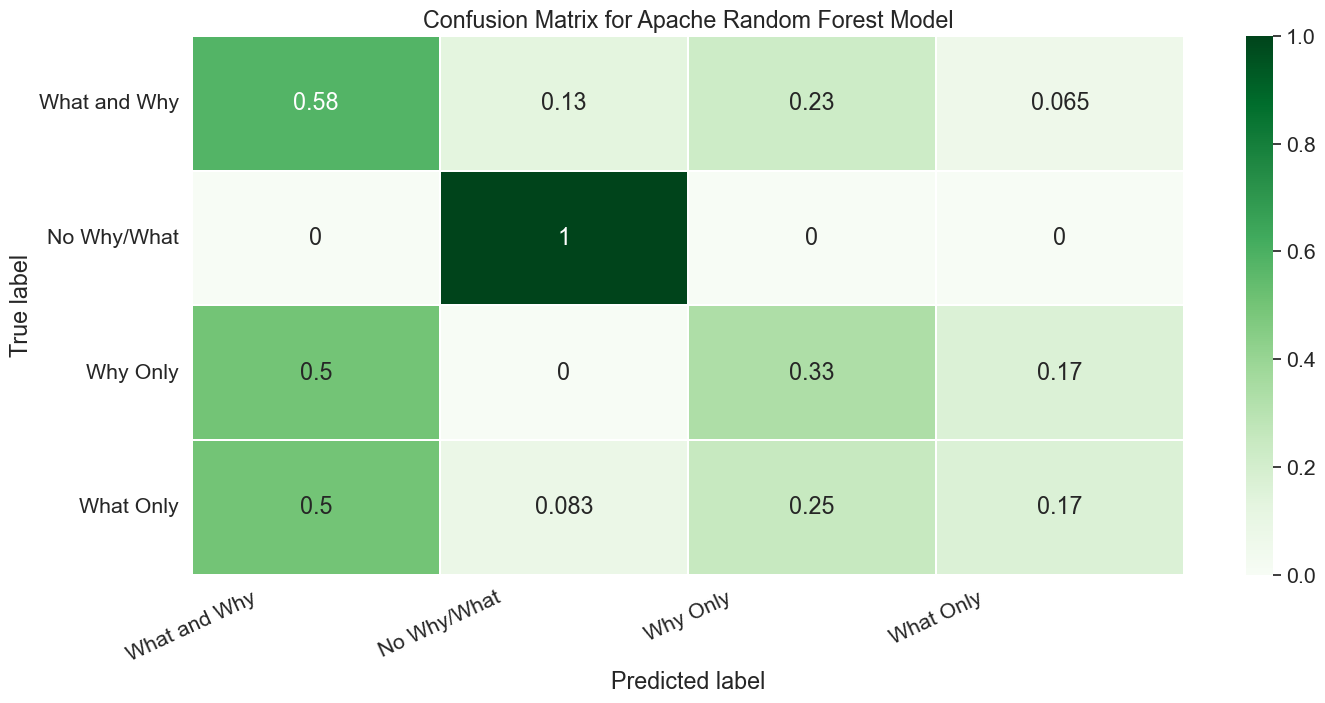

In [23]:
class_names=['What and Why', 'No Why/What', 'Why Only', 'What Only']
conf_matApache = confusion_matrix(test_labelsApache, predictionsApache, normalize='true')


plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matApache, annot=True,
            cmap=plt.cm.Greens, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Apache Random Forest Model')
plt.show()

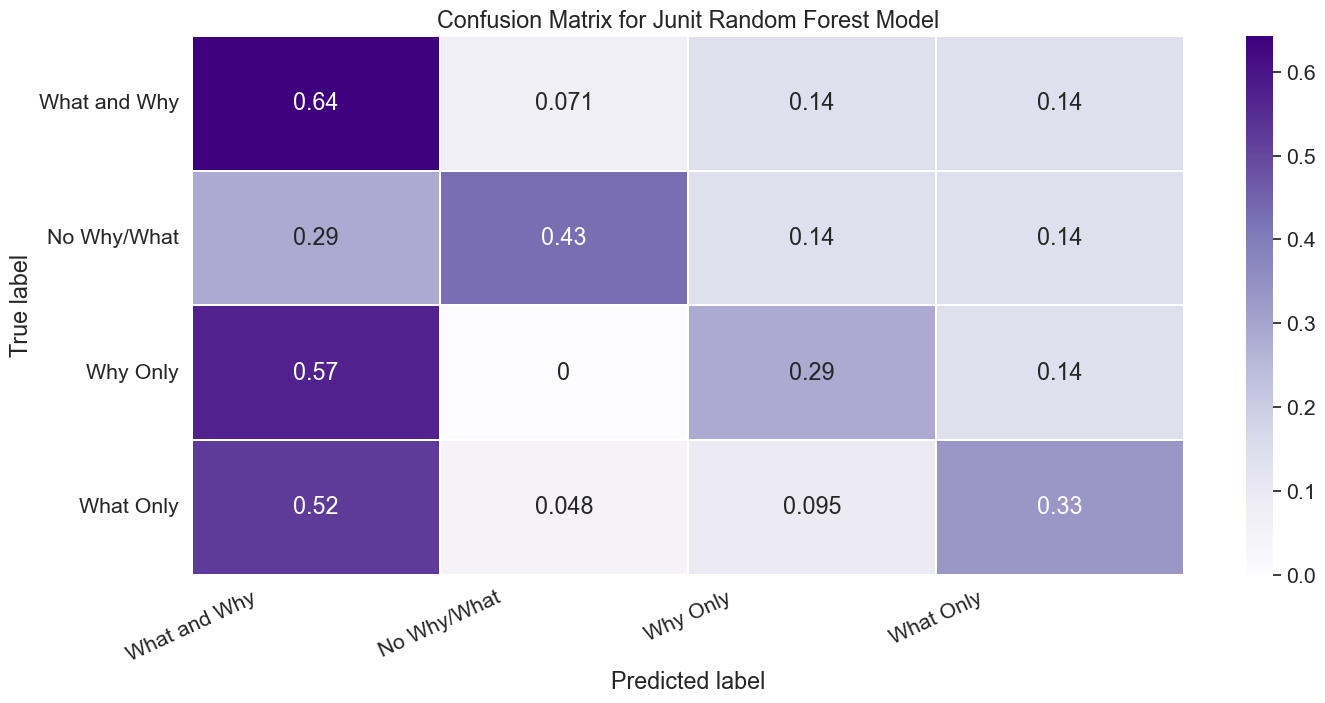

In [24]:
conf_matJunit = confusion_matrix(test_labelsJunit, predictionsJunit, normalize='true')


plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matJunit, annot=True,
            cmap=plt.cm.Purples, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Junit Random Forest Model')
plt.show()

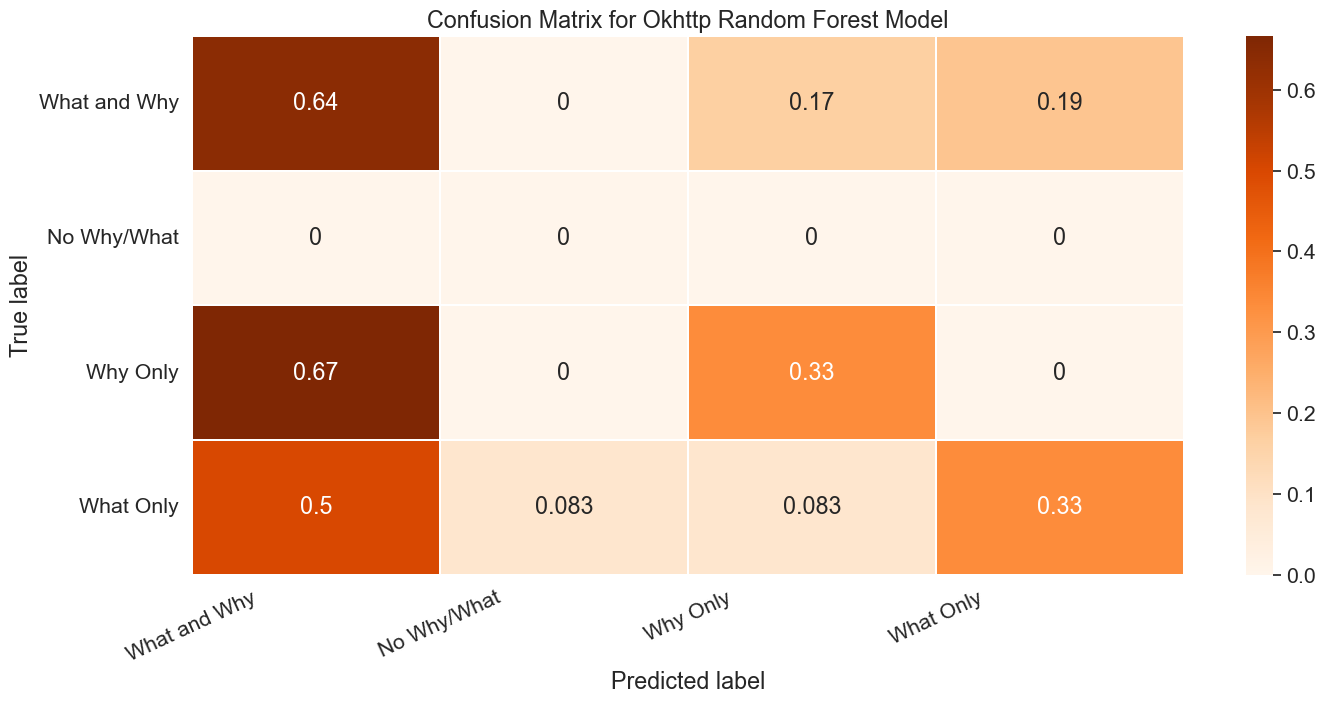

In [25]:
conf_matOkhttp = confusion_matrix(test_labelsOkhttp, predictionsOkhttp, normalize='true')


plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matOkhttp, annot=True,
            cmap=plt.cm.Oranges, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Okhttp Random Forest Model')
plt.show()

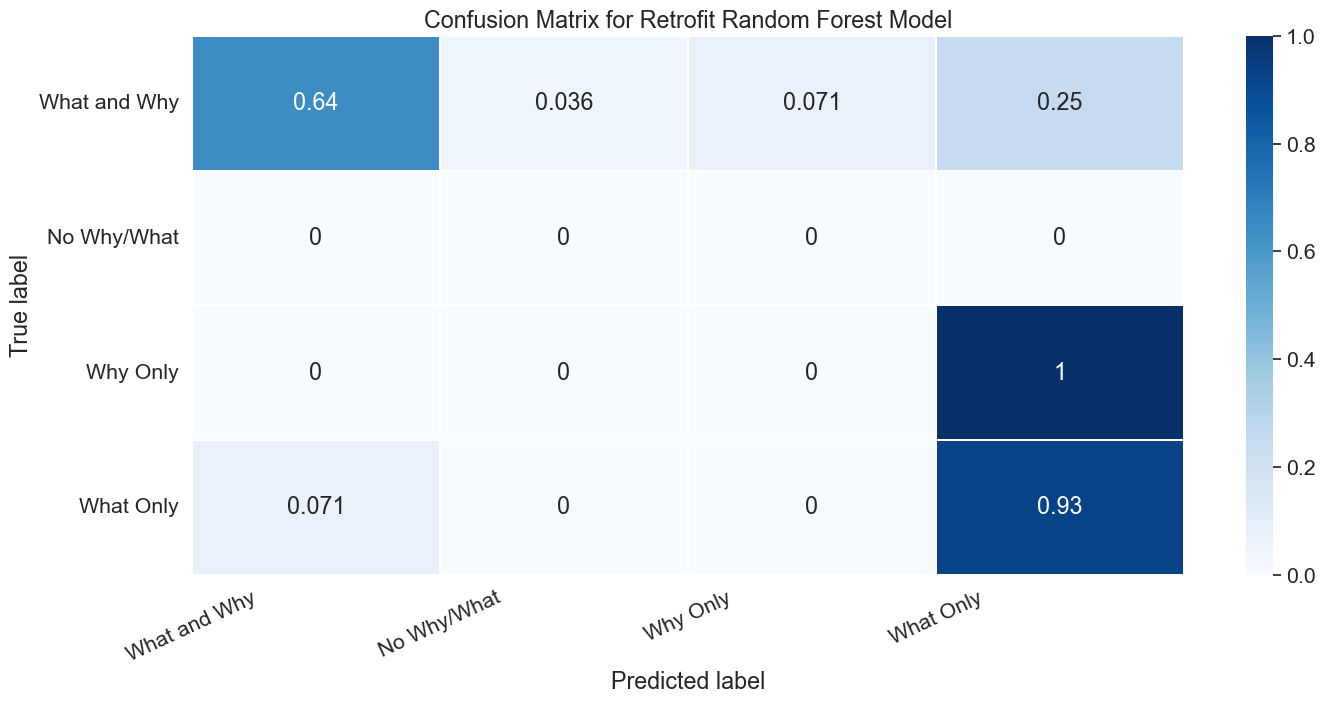

In [26]:
conf_matRetrofit = confusion_matrix(test_labelsRetrofit, predictionsRetrofit, normalize='true')


plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matRetrofit, annot=True,
            cmap=plt.cm.Blues, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Retrofit Random Forest Model')
plt.show()

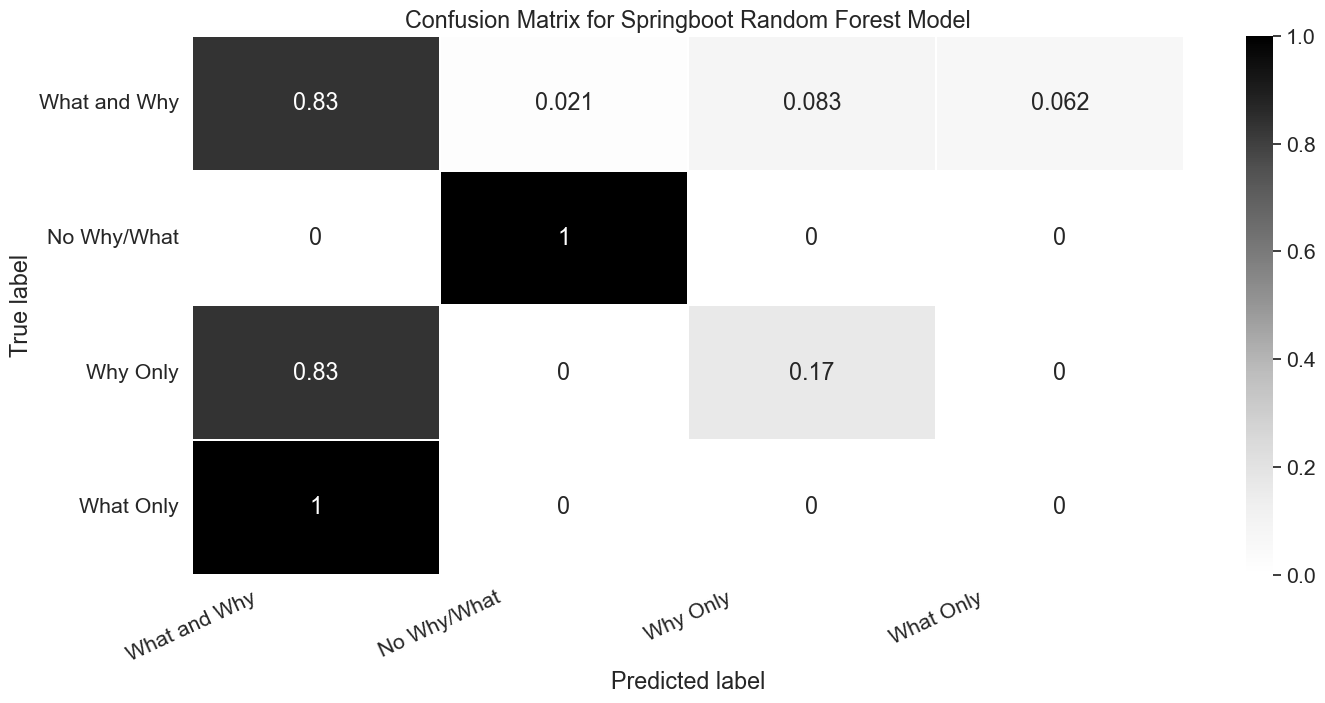

In [27]:
conf_matSpringboot = confusion_matrix(test_labelsSpringboot, predictionsSpringboot, normalize='true')


plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matSpringboot, annot=True,
            cmap=plt.cm.Greys, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Springboot Random Forest Model')
plt.show()